In [7]:
import torch
import numpy as np
import json
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = Path("data/processed")
mimiciv_icd9_path = data_dir / "mimiciv_icd9"
mimiciv_icd10_path = data_dir / "mimiciv_icd10"


def validate_dataset(dataset_path, name):
    print(f"\n{'='*50}")
    print(f"Validating {name} dataset")
    print(f"{'='*50}")

    # Check if dataset exists
    if not dataset_path.exists():
        print(f"ERROR: {dataset_path} does not exist!")
        return None

    # Load dataset
    try:
        dataset = load_dataset(str(dataset_path))
        print(f"✓ Successfully loaded dataset from {dataset_path}")
    except Exception as e:
        print(f"ERROR: Failed to load dataset: {e}")
        return None

    # Print dataset info
    print("\nDataset structure:")
    print(f"- Splits: {list(dataset.keys())}")
    for split in dataset.keys():
        print(f"- {split} split: {len(dataset[split])} examples")

    # Check columns
    expected_columns = ["text", "targets", "hadm_id"]
    print("\nChecking expected columns...")
    split = list(dataset.keys())[0]  # Use first split
    actual_columns = dataset[split].column_names
    print(f"- Found columns: {actual_columns}")

    missing_columns = [col for col in expected_columns if col not in actual_columns]
    if missing_columns:
        print(f":warning: Missing expected columns: {missing_columns}")
        # Check if alternative columns exist
        if "targets" in missing_columns and "diagnosis_codes" in actual_columns:
            print(
                "  ℹ️ 'diagnosis_codes' column is available as alternative to 'targets'"
            )
    else:
        print("✓ All expected columns are present")

    # Check for empty text fields
    if "text" in actual_columns:
        empty_texts = dataset[split].filter(
            lambda x: not x["text"] or len(x["text"]) < 10
        )
        if len(empty_texts) > 0:
            print(
                f":warning: Found {len(empty_texts)} examples with empty or very short text fields"
            )
        else:
            print("✓ No empty text fields detected")

    # Check codes
    code_column = (
        "targets"
        if "targets" in actual_columns
        else "diagnosis_codes"
        if "diagnosis_codes" in actual_columns
        else None
    )
    if code_column:
        empty_codes = dataset[split].filter(
            lambda x: not x[code_column] or len(x[code_column]) == 0
        )
        if len(empty_codes) > 0:
            print(f":warning: Found {len(empty_codes)} examples with no {code_column}")
            percent_empty = (len(empty_codes) / len(dataset[split])) * 100
            print(f"  ({percent_empty:.2f}% of the dataset)")
        else:
            print(f"✓ All examples have {code_column}")

        # Analyze code distribution
        all_codes = []
        for example in dataset[split][code_column]:
            if example is not None:
                all_codes.extend(example if isinstance(example, list) else [example])

        unique_codes = set(all_codes)
        print(f"\n{code_column} statistics:")
        print(f"- Total code occurrences: {len(all_codes)}")
        print(f"- Unique codes: {len(unique_codes)}")
        print(f"- Average codes per example: {len(all_codes)/len(dataset[split]):.2f}")

        # Display most common codes
        code_counts = pd.Series(all_codes).value_counts()
        print("\nTop 10 most common codes:")
        print(code_counts.head(10))

    # Show example
    print("\nSample example:")
    example = dataset[split][0]
    for key, value in example.items():
        if key == "text" and isinstance(value, str) and len(value) > 500:
            print(f"{key}: {value[:500]}...")
        else:
            print(f"{key}: {value}")

    return dataset


# Validate the MIMIC-IV datasets
mimiciv_icd9 = validate_dataset(mimiciv_icd9_path, "MIMIC-IV ICD-9")
mimiciv_icd10 = validate_dataset(mimiciv_icd10_path, "MIMIC-IV ICD-10")


Validating MIMIC-IV ICD-9 dataset
✓ Successfully loaded dataset from data/processed/mimiciv_icd9

Dataset structure:
- Splits: ['train', 'validation', 'test']
- train split: 154542 examples
- validation split: 21980 examples
- test split: 32804 examples

Checking expected columns...
- Found columns: ['note_id', 'subject_id', '_id', 'note_type', 'text', 'diagnosis_code_type', 'procedure_code_type', 'diagnosis_codes', 'procedure_codes']
:warning: Missing expected columns: ['targets', 'hadm_id']
  ℹ️ 'diagnosis_codes' column is available as alternative to 'targets'


Filter:   0%|          | 0/154542 [00:00<?, ? examples/s]

✓ No empty text fields detected


Filter:   0%|          | 0/154542 [00:00<?, ? examples/s]

:warning: Found 31 examples with no diagnosis_codes
  (0.02% of the dataset)

diagnosis_codes statistics:
- Total code occurrences: 1789684
- Unique codes: 4790
- Average codes per example: 11.58

Top 10 most common codes:
401.9     60304
272.4     42730
530.81    30893
250.00    25580
428.0     23830
427.31    23809
414.01    22500
V15.82    21279
311       20602
584.9     19792
Name: count, dtype: int64

Sample example:
note_id: 17862404-DS-20
subject_id: 17862404
_id: 22398820
note_type: discharge_summary
text:  
Name:  ___                       Unit No:   ___
 
Admission Date:  ___              Discharge Date:   ___
 
Date of Birth:  ___             Sex:   M
 
Service: NEUROSURGERY
 
Allergies: 
No Known Allergies / Adverse Drug Reactions
 
Attending: ___.
 
Chief Complaint:
S/P FALL
 
Major Surgical or Invasive Procedure:
NONE

 
History of Present Illness:
___ from ___ who fell today. He says he was dizzy and fell
and hit his head. There was no loss of consciousness but on
arriva

Filter:   0%|          | 0/89098 [00:00<?, ? examples/s]

✓ No empty text fields detected


Filter:   0%|          | 0/89098 [00:00<?, ? examples/s]

:warning: Found 19 examples with no diagnosis_codes
  (0.02% of the dataset)

diagnosis_codes statistics:
- Total code occurrences: 1259934
- Unique codes: 5800
- Average codes per example: 14.14

Top 10 most common codes:
E78.5      32176
I10        31718
Z87.891    26428
K21.9      22374
F32.9      16602
I25.10     16308
N17.9      14377
F41.9      13693
Z79.01     11143
Z79.4      11006
Name: count, dtype: int64

Sample example:
note_id: 18806652-DS-13
subject_id: 18806652
_id: 22605807
note_type: discharge_summary
text:  
Name:  ___                    Unit No:   ___
 
Admission Date:  ___              Discharge Date:   ___
 
Date of Birth:  ___             Sex:   F
 
Service: MEDICINE
 
Allergies: 
Morphine / Bactrim DS
 
Attending: ___.
 
Chief Complaint:
Back Pain
 
Major Surgical or Invasive Procedure:
Pharmacologic Stress Test

 
History of Present Illness:
 Ms. ___ is a ___ female with history of COPD on
nocturnal 2L NC, CAD, HTN, HL, T2DM on insulin, GERD, and 
chronic
back p

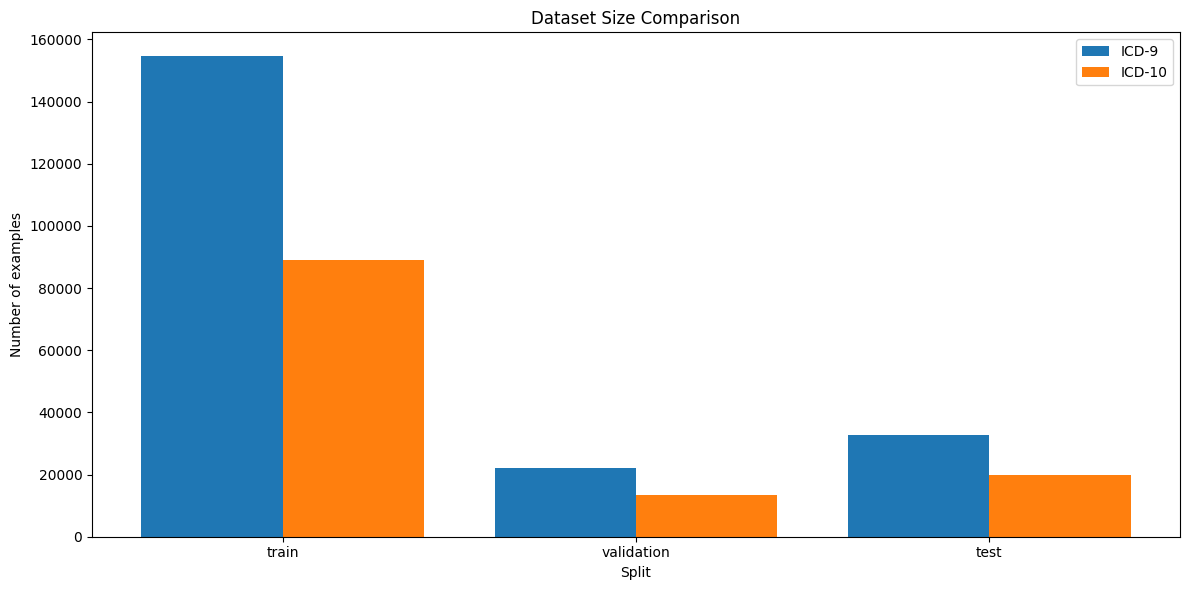

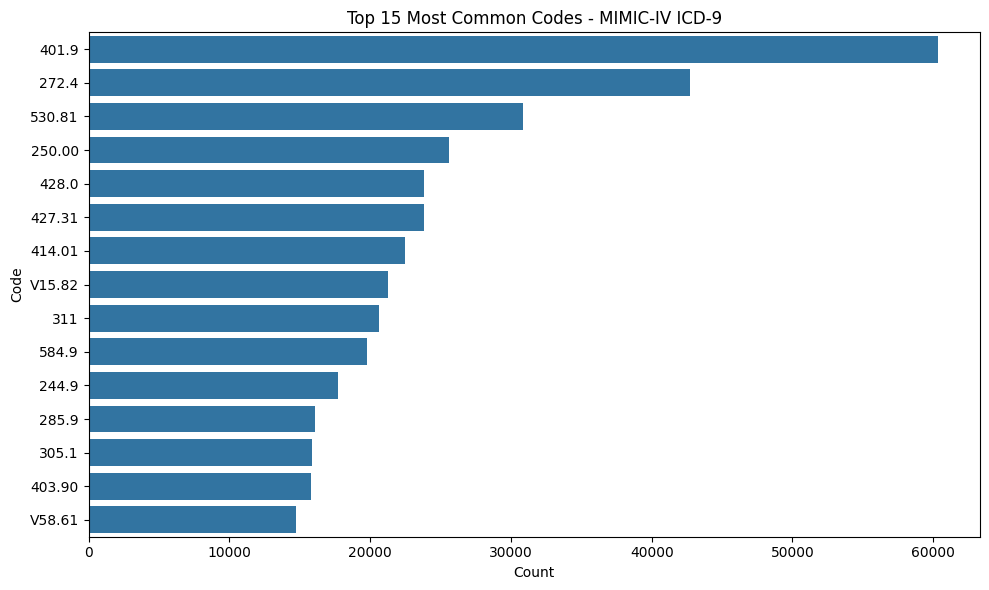

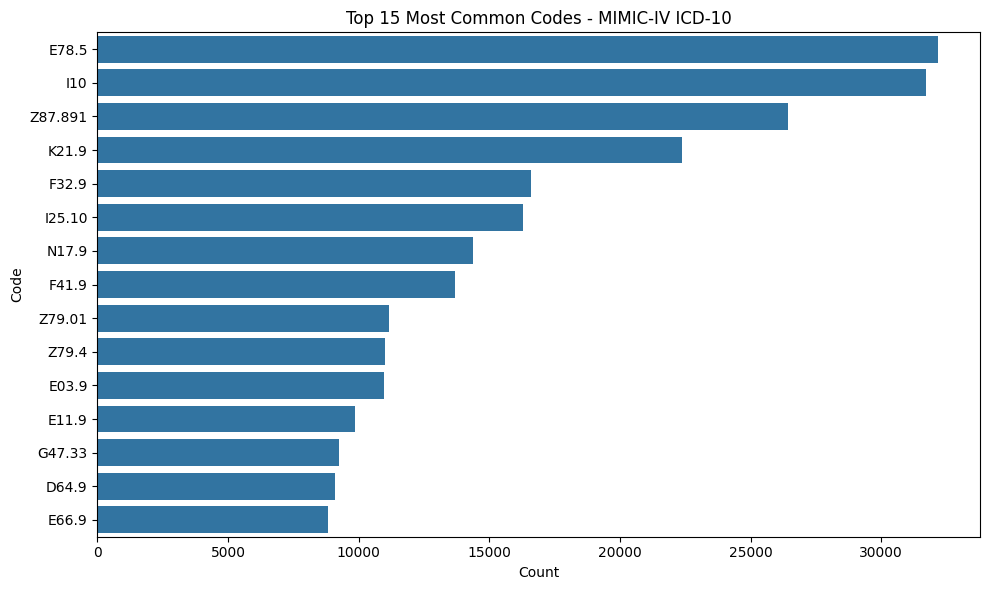

In [3]:
# Plot some visualizations if both datasets are loaded successfully
if mimiciv_icd9 and mimiciv_icd10:
    plt.figure(figsize=(12, 6))

    # Compare dataset sizes
    splits = ["train", "validation", "test"]
    sizes_icd9 = [len(mimiciv_icd9[s]) if s in mimiciv_icd9 else 0 for s in splits]
    sizes_icd10 = [len(mimiciv_icd10[s]) if s in mimiciv_icd10 else 0 for s in splits]

    x = range(len(splits))
    plt.bar([i - 0.2 for i in x], sizes_icd9, width=0.4, label="ICD-9")
    plt.bar([i + 0.2 for i in x], sizes_icd10, width=0.4, label="ICD-10")

    plt.xlabel("Split")
    plt.ylabel("Number of examples")
    plt.title("Dataset Size Comparison")
    plt.xticks(x, splits)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Fix the plot_c`ode_distribution function to handle missing 'targets' column
    def plot_code_distribution(dataset, title, n=15):
        split = list(dataset.keys())[0]

        # Check which columns are available and use appropriate ones
        columns = dataset[split].column_names

        if "targets" in columns:
            code_column = "targets"
        elif "diagnosis_codes" in columns:
            code_column = "diagnosis_codes"
        else:
            print(f"Warning: No code column found in {title} dataset")
            return

        all_codes = []
        for example in dataset[split][code_column]:
            if example is not None:  # Check for None values
                all_codes.extend(example if isinstance(example, list) else [example])

        if not all_codes:
            print(f"Warning: No codes found in {title} dataset")
            return

        code_counts = pd.Series(all_codes).value_counts().head(n)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=code_counts.values, y=code_counts.index)
        plt.xlabel("Count")
        plt.ylabel("Code")
        plt.title(f"Top {n} Most Common Codes - {title}")
        plt.tight_layout()
        plt.show()

    plot_code_distribution(mimiciv_icd9, "MIMIC-IV ICD-9")
    plot_code_distribution(mimiciv_icd10, "MIMIC-IV ICD-10")

In [9]:
# Path to your saved model
MODEL_PATH = Path(
    "~/git/explainable-medical-coding/outputs/PLMICD/final_model"
).expanduser()

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

# Load code mappings
with open(MODEL_PATH / "idx_to_code.json", "r") as f:
    idx_to_code = json.load(f)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Load dataset
dataset = load_dataset("explainable_medical_coding/datasets/mimiciv_icd9.py")
test_dataset = dataset["test"]


def predict_codes(text, threshold=0.5):
    # Tokenize input
    inputs = tokenizer(
        text,
        padding=True,
        truncation=True,
        max_length=6000,  # Same as training
        return_tensors="pt",
    ).to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Apply sigmoid and threshold
    probs = torch.sigmoid(logits)
    predictions = (probs >= threshold).cpu().numpy()

    # Get predicted codes
    predicted_codes = []
    for idx in np.where(predictions[0])[0]:
        code = idx_to_code[str(idx)]  # idx_to_code keys are strings
        prob = probs[0][idx].item()
        predicted_codes.append((code, prob))

    # Sort by probability
    predicted_codes.sort(key=lambda x: x[1], reverse=True)
    return predicted_codes


# Test on a few examples
for i in range(3):  # Test first 3 examples
    print(f"\nExample {i+1}:")
    print("Text:", test_dataset[i]["text"][:1000] + "...")  # Show first 200 chars
    print("\nTrue codes:", test_dataset[i]["diagnosis_codes"])

    predictions = predict_codes(test_dataset[i]["text"])
    print("\nPredicted codes (with probabilities):")
    for code, prob in predictions:
        print(f"{code}: {prob:.3f}")
    print("\n" + "=" * 50)


Example 1:
Text:  
Name:  ___                  Unit No:   ___
 
Admission Date:  ___              Discharge Date:   ___
 
Date of Birth:  ___             Sex:   M
 
Service: MEDICINE
 
Allergies: 
Heparin Agents / Coumadin / aspirin
 
Attending: ___
 
Chief Complaint:
hypokalemia
 
Major Surgical or Invasive Procedure:
none
 
History of Present Illness:
___ with EtOH cirrhosis, severe COPD, CKD stage ___ seen for 
routine scheduled visit today in ___ clinic and found to 
be hypokalemic to 2.9, called to return to ___ ED. 2 days PTA 
had 24 hours of projectile vomiting and diarrhea, and describes 
some cramps in his arms consistent with previous episode of 
hypokalemia. He has not felt lightheaded or dizzy, able to 
tolerate PO day after GI illness, back to regular solids on ___ 
night, day PTA.
Of note, he recently started smoking again, 1PPD because sister 
has been sick. He denies any wheezing, girlfriend says he 
wheezes a little at baseline, denies any shortness of breath, 
was do

[2025-04-01 19:00:19,183] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (64)
[2025-04-01 19:00:19,183] torch._dynamo.convert_frame: [WARNING]    function: 'compiled_mlp' (/home/tylercross/.cache/pypoetry/virtualenvs/explainable-medical-coding-IcR-e2oa-py3.11/lib/python3.11/site-packages/transformers/models/modernbert/modeling_modernbert.py:552)
[2025-04-01 19:00:19,183] torch._dynamo.convert_frame: [WARNING] to diagnose recompilation issues, set env variable TORCHDYNAMO_REPORT_GUARD_FAILURES=1 and also see https://pytorch.org/docs/master/compile/troubleshooting.html.



Predicted codes (with probabilities):
305.1: 0.999
276.8: 0.997
571.2: 0.994
428.33: 0.939
724.5: 0.863
456.21: 0.828
403.90: 0.726
799.02: 0.660
496: 0.516


Example 2:
Text:  
Name:  ___                  Unit No:   ___
 
Admission Date:  ___              Discharge Date:   ___
 
Date of Birth:  ___             Sex:   F
 
Service: UROLOGY
 
Allergies: 
No Known Allergies / Adverse Drug Reactions
 
Attending: ___.
 
Chief Complaint:
left adrenal mass
 
Major Surgical or Invasive Procedure:
left laparoscopic adrenalectomy

 
History of Present Illness:
___, today who is here with her husband, ___, regarding 
her left adrenal mass.  She is ___.  She had a CT chest done in 
___ for a left breast lump, which incidentally picked up a 
moderate-sized left adrenal mass.  An
MRI was then performed in ___ showing some increase in size of 
the mass up to 5.3 cm.  These scans were reviewed personally 
today.  The kidneys appear unremarkable as does the left of 
pancreas, spleen.  The mass appears